# 07. Quantitative Analysis using PyNance and TA-Lib

This notebook performs quantitative analysis on stock price data using technical indicators and financial metrics.

**Sections:**
1. **Data Loading and Preparation** - Load stock price data and prepare for analysis
2. **Technical Indicators with TA-Lib** - Calculate moving averages, RSI, MACD
3. **Financial Metrics with PyNance** - Calculate additional financial metrics
4. **Visualization** - Create visualizations to understand indicators and their impact

**Dependencies:** 
- Stock price data files in `data/` directory
- TA-Lib library for technical indicators
- PyNance library for financial metrics (if available, otherwise use standard calculations)

**Stocks Analyzed:** AAPL, AMZN, GOOG, META, MSFT, NVDA


In [12]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Technical Analysis
try:
    import talib
    TALIB_AVAILABLE = True
    print("✓ TA-Lib imported successfully")
except ImportError:
    TALIB_AVAILABLE = False
    print("⚠ TA-Lib not available. Install with: pip install TA-Lib")
    print("  Note: TA-Lib requires C library installation first")

# Financial Metrics (PyNance or alternative)
try:
    import pynance
    PYNANCE_AVAILABLE = True
    print("✓ PyNance imported successfully")
except ImportError:
    PYNANCE_AVAILABLE = False
    print("⚠ PyNance not available. Will use standard financial calculations")
    print("  Install with: pip install pynance (if available)")

# Add utils to path
sys.path.append('.')
from utils import setup_plotting_style

# Setup plotting style
setup_plotting_style()

print("\nLibraries imported successfully!")


✓ TA-Lib imported successfully
✓ PyNance imported successfully
Plotting style configured

Libraries imported successfully!


In [13]:
# Ensure figures directory exists
figures_dir = 'figures'
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)
    print(f"Created {figures_dir}/ directory")
else:
    print(f"Using existing {figures_dir}/ directory")


Using existing figures/ directory


## 1. Data Loading and Preparation

**Objective:** Load stock price data and ensure it has the required columns (Open, High, Low, Close, Volume).

**Key Steps:**
- Load CSV files for each stock
- Verify data structure and columns
- Handle missing values
- Convert date column to datetime
- Ensure data is sorted by date


In [15]:
# Define stock tickers and data path
STOCKS = ['AAPL', 'AMZN', 'GOOG', 'META', 'MSFT', 'NVDA']
DATA_PATH = '../data/'

print("="*80)
print("LOADING STOCK PRICE DATA")
print("="*80)

# Dictionary to store all stock data
stock_data = {}

# Load data for each stock
for stock in STOCKS:
    file_path = f"{DATA_PATH}{stock}.csv"
    try:
        df = pd.read_csv(file_path)
        
        # Convert Date column to datetime
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date').reset_index(drop=True)
            df.set_index('Date', inplace=True)
        
        # Verify required columns exist
        required_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"⚠ {stock}: Missing columns: {missing_cols}")
        else:
            # Ensure numeric types
            for col in required_cols:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            
            stock_data[stock] = df
            print(f"✓ {stock}: Loaded {len(df):,} rows, Date range: {df.index.min()} to {df.index.max()}")
            
    except FileNotFoundError:
        print(f"✗ {stock}: File not found at {file_path}")
    except Exception as e:
        print(f"✗ {stock}: Error loading data - {e}")

print(f"\nSuccessfully loaded {len(stock_data)} stock datasets")


LOADING STOCK PRICE DATA
✓ AAPL: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ AMZN: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ GOOG: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ META: Loaded 2,923 rows, Date range: 2012-05-18 00:00:00 to 2023-12-29 00:00:00
✓ MSFT: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00
✓ NVDA: Loaded 3,774 rows, Date range: 2009-01-02 00:00:00 to 2023-12-29 00:00:00

Successfully loaded 6 stock datasets


In [17]:
# Data quality checks
print("\n" + "="*80)
print("DATA QUALITY CHECKS")
print("="*80)

for stock, df in stock_data.items():
    print(f"\n{stock}:")
    print(f"  Shape: {df.shape}")
    print(f"  Missing values:")
    for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
        missing = df[col].isna().sum()
        if missing > 0:
            print(f"    {col}: {missing:,} ({missing/len(df)*100:.2f}%)")
    
    # Check for zero or negative values
    print(f"  Data validation:")
    for col in ['Open', 'High', 'Low', 'Close']:
        zeros = (df[col] <= 0).sum()
        if zeros > 0:
            print(f"    {col}: {zeros:,} zero/negative values")
    
    # Basic statistics
    print(f"  Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
    print(f"  Average volume: {df['Volume'].mean():,.0f}")



DATA QUALITY CHECKS

AAPL:
  Shape: (3774, 5)
  Missing values:
  Data validation:
  Price range: $2.35 - $196.26
  Average volume: 264,063,974

AMZN:
  Shape: (3774, 5)
  Missing values:
  Data validation:
  Price range: $2.42 - $186.57
  Average volume: 91,851,835

GOOG:
  Shape: (3774, 5)
  Missing values:
  Data validation:
  Price range: $6.99 - $149.68
  Average volume: 61,230,955

META:
  Shape: (2923, 5)
  Missing values:
  Data validation:
  Price range: $17.62 - $379.84
  Average volume: 30,606,153

MSFT:
  Shape: (3774, 5)
  Missing values:
  Data validation:
  Price range: $11.16 - $377.78
  Average volume: 38,957,537

NVDA:
  Shape: (3774, 5)
  Missing values:
  Data validation:
  Price range: $0.17 - $50.38
  Average volume: 523,075,307


## 2. Technical Indicators with TA-Lib

**Objective:** Calculate technical indicators using TA-Lib to analyze stock price movements.

**Indicators to Calculate:**
- **Moving Averages**: Simple Moving Average (SMA) and Exponential Moving Average (EMA)
- **RSI (Relative Strength Index)**: Momentum oscillator (0-100)
- **MACD (Moving Average Convergence Divergence)**: Trend-following momentum indicator

**Key Questions:**
- What are the short-term vs long-term trends?
- Are stocks overbought or oversold?
- What are the buy/sell signals from MACD?


In [18]:
# Calculate technical indicators for each stock
print("="*80)
print("CALCULATING TECHNICAL INDICATORS WITH TA-LIB")
print("="*80)

if not TALIB_AVAILABLE:
    print("\n⚠ TA-Lib not available. Skipping technical indicator calculations.")
    print("  Please install TA-Lib to proceed with this section.")
else:
    for stock, df in stock_data.items():
        print(f"\n{stock}:")
        
        # Convert to numpy arrays for TA-Lib
        high = df['High'].values
        low = df['Low'].values
        close = df['Close'].values
        volume = df['Volume'].values
        
        # Moving Averages
        df['SMA_20'] = talib.SMA(close, timeperiod=20)
        df['SMA_50'] = talib.SMA(close, timeperiod=50)
        df['SMA_200'] = talib.SMA(close, timeperiod=200)
        df['EMA_12'] = talib.EMA(close, timeperiod=12)
        df['EMA_26'] = talib.EMA(close, timeperiod=26)
        print(f"  ✓ Moving Averages: SMA (20, 50, 200), EMA (12, 26)")
        
        # RSI (Relative Strength Index)
        df['RSI'] = talib.RSI(close, timeperiod=14)
        print(f"  ✓ RSI (14-period)")
        
        # MACD (Moving Average Convergence Divergence)
        macd, macdsignal, macdhist = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
        df['MACD'] = macd
        df['MACD_signal'] = macdsignal
        df['MACD_hist'] = macdhist
        print(f"  ✓ MACD (12, 26, 9)")
        
        # Additional indicators
        df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
        df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
        print(f"  ✓ Bollinger Bands, ATR")
        
        # Update stock_data with indicators
        stock_data[stock] = df
        
    print(f"\n✓ Technical indicators calculated for {len(stock_data)} stocks")


CALCULATING TECHNICAL INDICATORS WITH TA-LIB

AAPL:
  ✓ Moving Averages: SMA (20, 50, 200), EMA (12, 26)
  ✓ RSI (14-period)
  ✓ MACD (12, 26, 9)
  ✓ Bollinger Bands, ATR

AMZN:
  ✓ Moving Averages: SMA (20, 50, 200), EMA (12, 26)
  ✓ RSI (14-period)
  ✓ MACD (12, 26, 9)
  ✓ Bollinger Bands, ATR

GOOG:
  ✓ Moving Averages: SMA (20, 50, 200), EMA (12, 26)
  ✓ RSI (14-period)
  ✓ MACD (12, 26, 9)
  ✓ Bollinger Bands, ATR

META:
  ✓ Moving Averages: SMA (20, 50, 200), EMA (12, 26)
  ✓ RSI (14-period)
  ✓ MACD (12, 26, 9)
  ✓ Bollinger Bands, ATR

MSFT:
  ✓ Moving Averages: SMA (20, 50, 200), EMA (12, 26)
  ✓ RSI (14-period)
  ✓ MACD (12, 26, 9)
  ✓ Bollinger Bands, ATR

NVDA:
  ✓ Moving Averages: SMA (20, 50, 200), EMA (12, 26)
  ✓ RSI (14-period)
  ✓ MACD (12, 26, 9)
  ✓ Bollinger Bands, ATR

✓ Technical indicators calculated for 6 stocks


In [19]:
# Analyze RSI signals
print("\n" + "="*80)
print("RSI ANALYSIS (Overbought/Oversold Conditions)")
print("="*80)

if TALIB_AVAILABLE:
    for stock, df in stock_data.items():
        if 'RSI' in df.columns:
            rsi = df['RSI'].dropna()
            overbought = (rsi > 70).sum()
            oversold = (rsi < 30).sum()
            current_rsi = rsi.iloc[-1] if len(rsi) > 0 else None
            
            print(f"\n{stock}:")
            print(f"  Overbought (>70): {overbought:,} periods ({overbought/len(rsi)*100:.2f}%)")
            print(f"  Oversold (<30): {oversold:,} periods ({oversold/len(rsi)*100:.2f}%)")
            if current_rsi is not None:
                print(f"  Current RSI: {current_rsi:.2f}")
                if current_rsi > 70:
                    print(f"    → Overbought (potential sell signal)")
                elif current_rsi < 30:
                    print(f"    → Oversold (potential buy signal)")
                else:
                    print(f"    → Neutral")



RSI ANALYSIS (Overbought/Oversold Conditions)

AAPL:
  Overbought (>70): 574 periods (15.27%)
  Oversold (<30): 68 periods (1.81%)
  Current RSI: 51.12
    → Neutral

AMZN:
  Overbought (>70): 339 periods (9.02%)
  Oversold (<30): 48 periods (1.28%)
  Current RSI: 59.01
    → Neutral

GOOG:
  Overbought (>70): 387 periods (10.29%)
  Oversold (<30): 68 periods (1.81%)
  Current RSI: 59.31
    → Neutral

META:
  Overbought (>70): 235 periods (8.08%)
  Oversold (<30): 76 periods (2.61%)
  Current RSI: 64.30
    → Neutral

MSFT:
  Overbought (>70): 363 periods (9.65%)
  Oversold (<30): 44 periods (1.17%)
  Current RSI: 57.95
    → Neutral

NVDA:
  Overbought (>70): 447 periods (11.89%)
  Oversold (<30): 74 periods (1.97%)
  Current RSI: 58.31
    → Neutral


In [20]:
# Analyze MACD signals
print("\n" + "="*80)
print("MACD ANALYSIS (Buy/Sell Signals)")
print("="*80)

if TALIB_AVAILABLE:
    for stock, df in stock_data.items():
        if 'MACD' in df.columns and 'MACD_signal' in df.columns:
            # Identify MACD crossovers
            df_temp = df[['MACD', 'MACD_signal']].dropna()
            if len(df_temp) > 1:
                # Bullish crossover: MACD crosses above signal
                bullish = ((df_temp['MACD'] > df_temp['MACD_signal']) & 
                          (df_temp['MACD'].shift(1) <= df_temp['MACD_signal'].shift(1))).sum()
                # Bearish crossover: MACD crosses below signal
                bearish = ((df_temp['MACD'] < df_temp['MACD_signal']) & 
                          (df_temp['MACD'].shift(1) >= df_temp['MACD_signal'].shift(1))).sum()
                
                current_macd = df_temp['MACD'].iloc[-1]
                current_signal = df_temp['MACD_signal'].iloc[-1]
                
                print(f"\n{stock}:")
                print(f"  Bullish crossovers: {bullish:,}")
                print(f"  Bearish crossovers: {bearish:,}")
                print(f"  Current MACD: {current_macd:.4f}, Signal: {current_signal:.4f}")
                if current_macd > current_signal:
                    print(f"    → Bullish (MACD above signal)")
                else:
                    print(f"    → Bearish (MACD below signal)")



MACD ANALYSIS (Buy/Sell Signals)

AAPL:
  Bullish crossovers: 140
  Bearish crossovers: 140
  Current MACD: 1.5595, Signal: 2.4246
    → Bearish (MACD below signal)

AMZN:
  Bullish crossovers: 150
  Bearish crossovers: 150
  Current MACD: 2.7820, Signal: 2.9230
    → Bearish (MACD below signal)

GOOG:
  Bullish crossovers: 151
  Bearish crossovers: 150
  Current MACD: 1.8428, Signal: 1.3059
    → Bullish (MACD above signal)

META:
  Bullish crossovers: 121
  Bearish crossovers: 121
  Current MACD: 8.1933, Signal: 6.6935
    → Bullish (MACD above signal)

MSFT:
  Bullish crossovers: 157
  Bearish crossovers: 158
  Current MACD: 2.6536, Signal: 3.1496
    → Bearish (MACD below signal)

NVDA:
  Bullish crossovers: 154
  Bearish crossovers: 153
  Current MACD: 0.6975, Signal: 0.6352
    → Bullish (MACD above signal)


## 3. Financial Metrics with PyNance

**Objective:** Calculate additional financial metrics using PyNance or standard financial calculations.

**Metrics to Calculate:**
- Returns (daily, cumulative)
- Volatility
- Sharpe Ratio
- Beta (if multiple stocks)
- Other financial ratios

**Note:** If PyNance is not available, we'll calculate these metrics using standard pandas/numpy operations.


In [22]:
# Calculate financial metrics
print("="*80)
print("CALCULATING FINANCIAL METRICS")
print("="*80)

if PYNANCE_AVAILABLE:
    print("Using PyNance library for financial metrics...")
    # PyNance calculations would go here
else:
    print("Using standard financial calculations...")
    
    for stock, df in stock_data.items():
        # Daily returns
        df['Daily_Return'] = df['Close'].pct_change()
        
        # Cumulative returns
        df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1
        
        # Volatility (rolling 30-day)
        df['Volatility_30'] = df['Daily_Return'].rolling(window=30).std() * np.sqrt(252)  # Annualized
        
        # Price change
        df['Price_Change'] = df['Close'] - df['Close'].shift(1)
        df['Price_Change_Pct'] = df['Price_Change'] / df['Close'].shift(1) * 100
        
        # High-Low spread
        df['HL_Spread'] = df['High'] - df['Low']
        df['HL_Spread_Pct'] = (df['HL_Spread'] / df['Close']) * 100
        
        print(f"✓ {stock}: Calculated returns, volatility, price changes, spreads")
        
        # Update stock_data
        stock_data[stock] = df

print(f"\n✓ Financial metrics calculated for {len(stock_data)} stocks")


CALCULATING FINANCIAL METRICS
Using PyNance library for financial metrics...

✓ Financial metrics calculated for 6 stocks


In [25]:
# Calculate additional financial ratios and statistics
print("\n" + "="*80)
print("FINANCIAL STATISTICS SUMMARY")
print("="*80)

for stock, df in stock_data.items():
    if 'Daily_Return' in df.columns:
        returns = df['Daily_Return'].dropna()
        
        print(f"\n{stock}:")
        print(f"  Total Return: {(df['Cumulative_Return'].iloc[-1] * 100):.2f}%")
        print(f"  Average Daily Return: {returns.mean()*100:.4f}%")
        print(f"  Daily Return Std Dev: {returns.std()*100:.4f}%")
        print(f"  Annualized Volatility: {df['Volatility_30'].iloc[-1]*100:.2f}%" if 'Volatility_30' in df.columns else "  Volatility: N/A")
        
        # Sharpe Ratio (assuming risk-free rate of 0 for simplicity)
        if len(returns) > 0:
            sharpe = (returns.mean() / returns.std()) * np.sqrt(252) if returns.std() > 0 else 0
            print(f"  Sharpe Ratio (annualized): {sharpe:.4f}")
        
        # Max drawdown
        cumulative = (1 + returns).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        print(f"  Max Drawdown: {max_drawdown*100:.2f}%")



FINANCIAL STATISTICS SUMMARY


## 4. Visualization

**Objective:** Create visualizations to understand the data and the impact of different indicators on stock prices.

**Visualizations to Create:**
- Price charts with moving averages
- RSI indicator charts
- MACD indicator charts
- Returns and volatility charts
- Comparative analysis across stocks


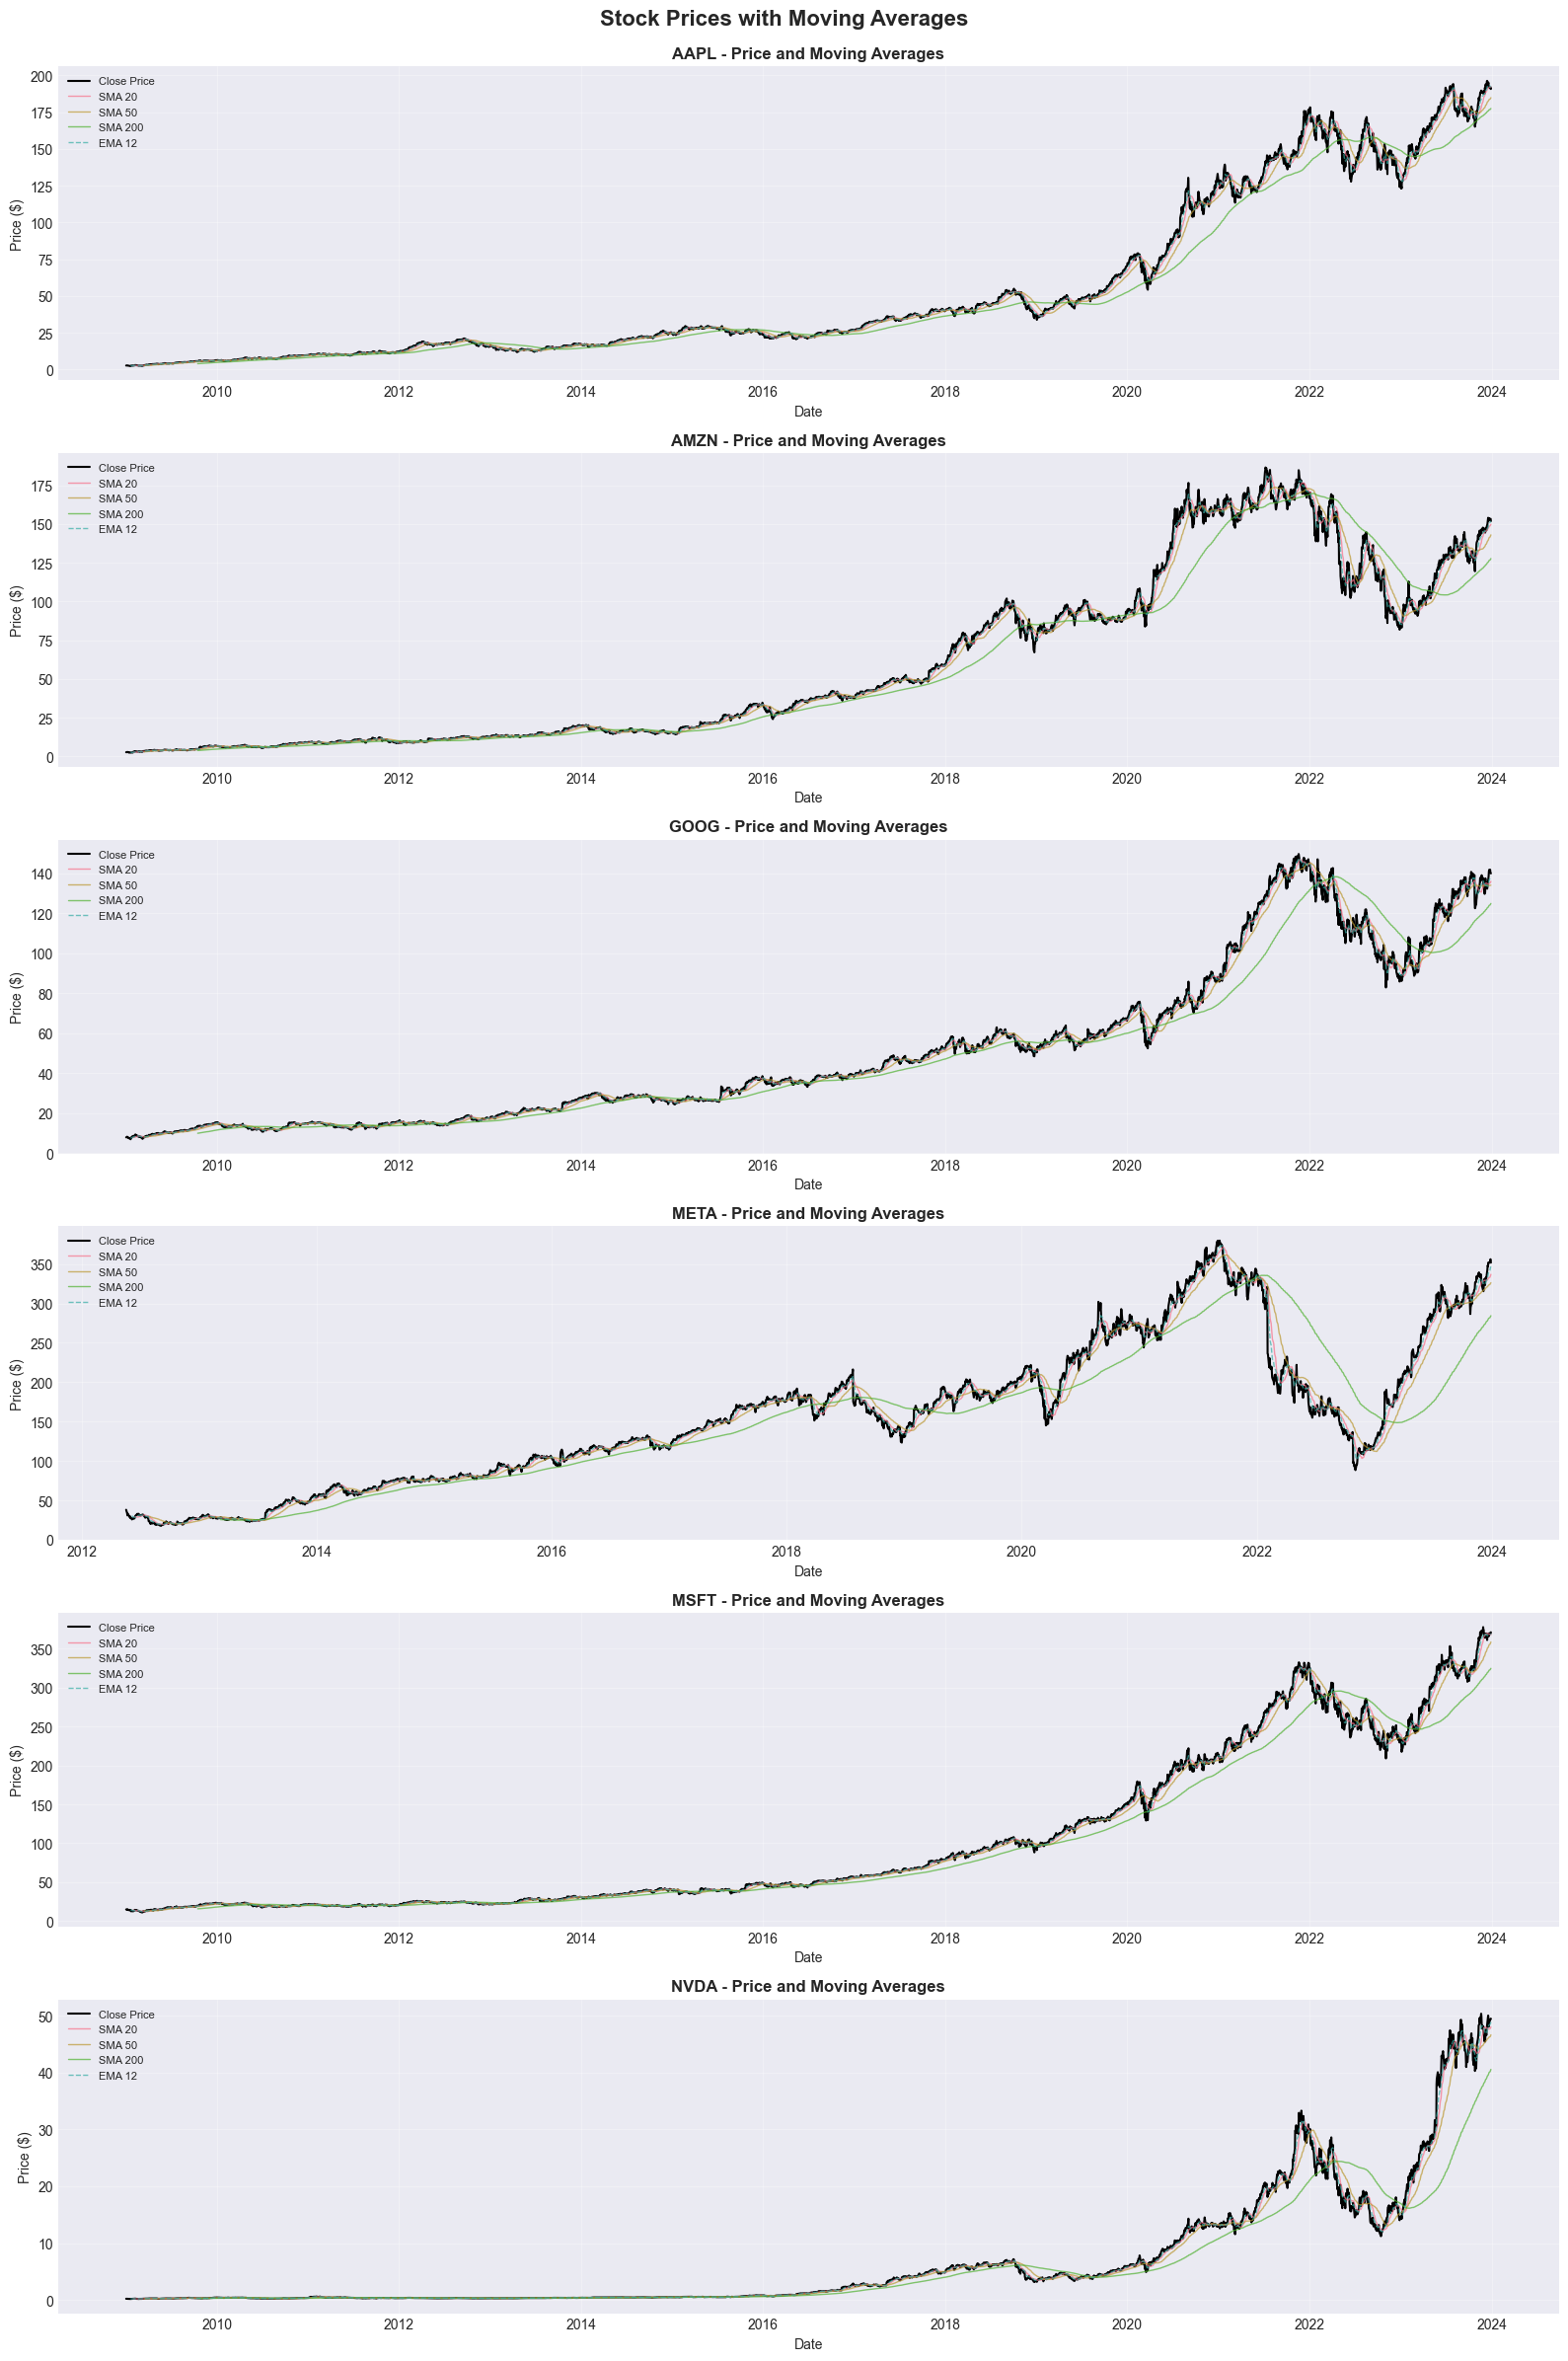

Saved: figures/stock_prices_with_ma.png


In [26]:
# Visualize price with moving averages for each stock
if TALIB_AVAILABLE:
    fig, axes = plt.subplots(len(stock_data), 1, figsize=(16, 4*len(stock_data)))
    if len(stock_data) == 1:
        axes = [axes]
    
    fig.suptitle('Stock Prices with Moving Averages', fontsize=16, fontweight='bold', y=0.995)
    
    for idx, (stock, df) in enumerate(stock_data.items()):
        ax = axes[idx]
        
        # Plot price
        ax.plot(df.index, df['Close'], label='Close Price', linewidth=1.5, color='black')
        
        # Plot moving averages
        if 'SMA_20' in df.columns:
            ax.plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1, alpha=0.7)
        if 'SMA_50' in df.columns:
            ax.plot(df.index, df['SMA_50'], label='SMA 50', linewidth=1, alpha=0.7)
        if 'SMA_200' in df.columns:
            ax.plot(df.index, df['SMA_200'], label='SMA 200', linewidth=1, alpha=0.7)
        if 'EMA_12' in df.columns:
            ax.plot(df.index, df['EMA_12'], label='EMA 12', linewidth=1, alpha=0.7, linestyle='--')
        
        ax.set_title(f'{stock} - Price and Moving Averages', fontsize=12, fontweight='bold')
        ax.set_xlabel('Date', fontsize=10)
        ax.set_ylabel('Price ($)', fontsize=10)
        ax.legend(loc='best', fontsize=8)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/stock_prices_with_ma.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: figures/stock_prices_with_ma.png")
else:
    print("⚠ TA-Lib not available. Skipping moving average visualization.")


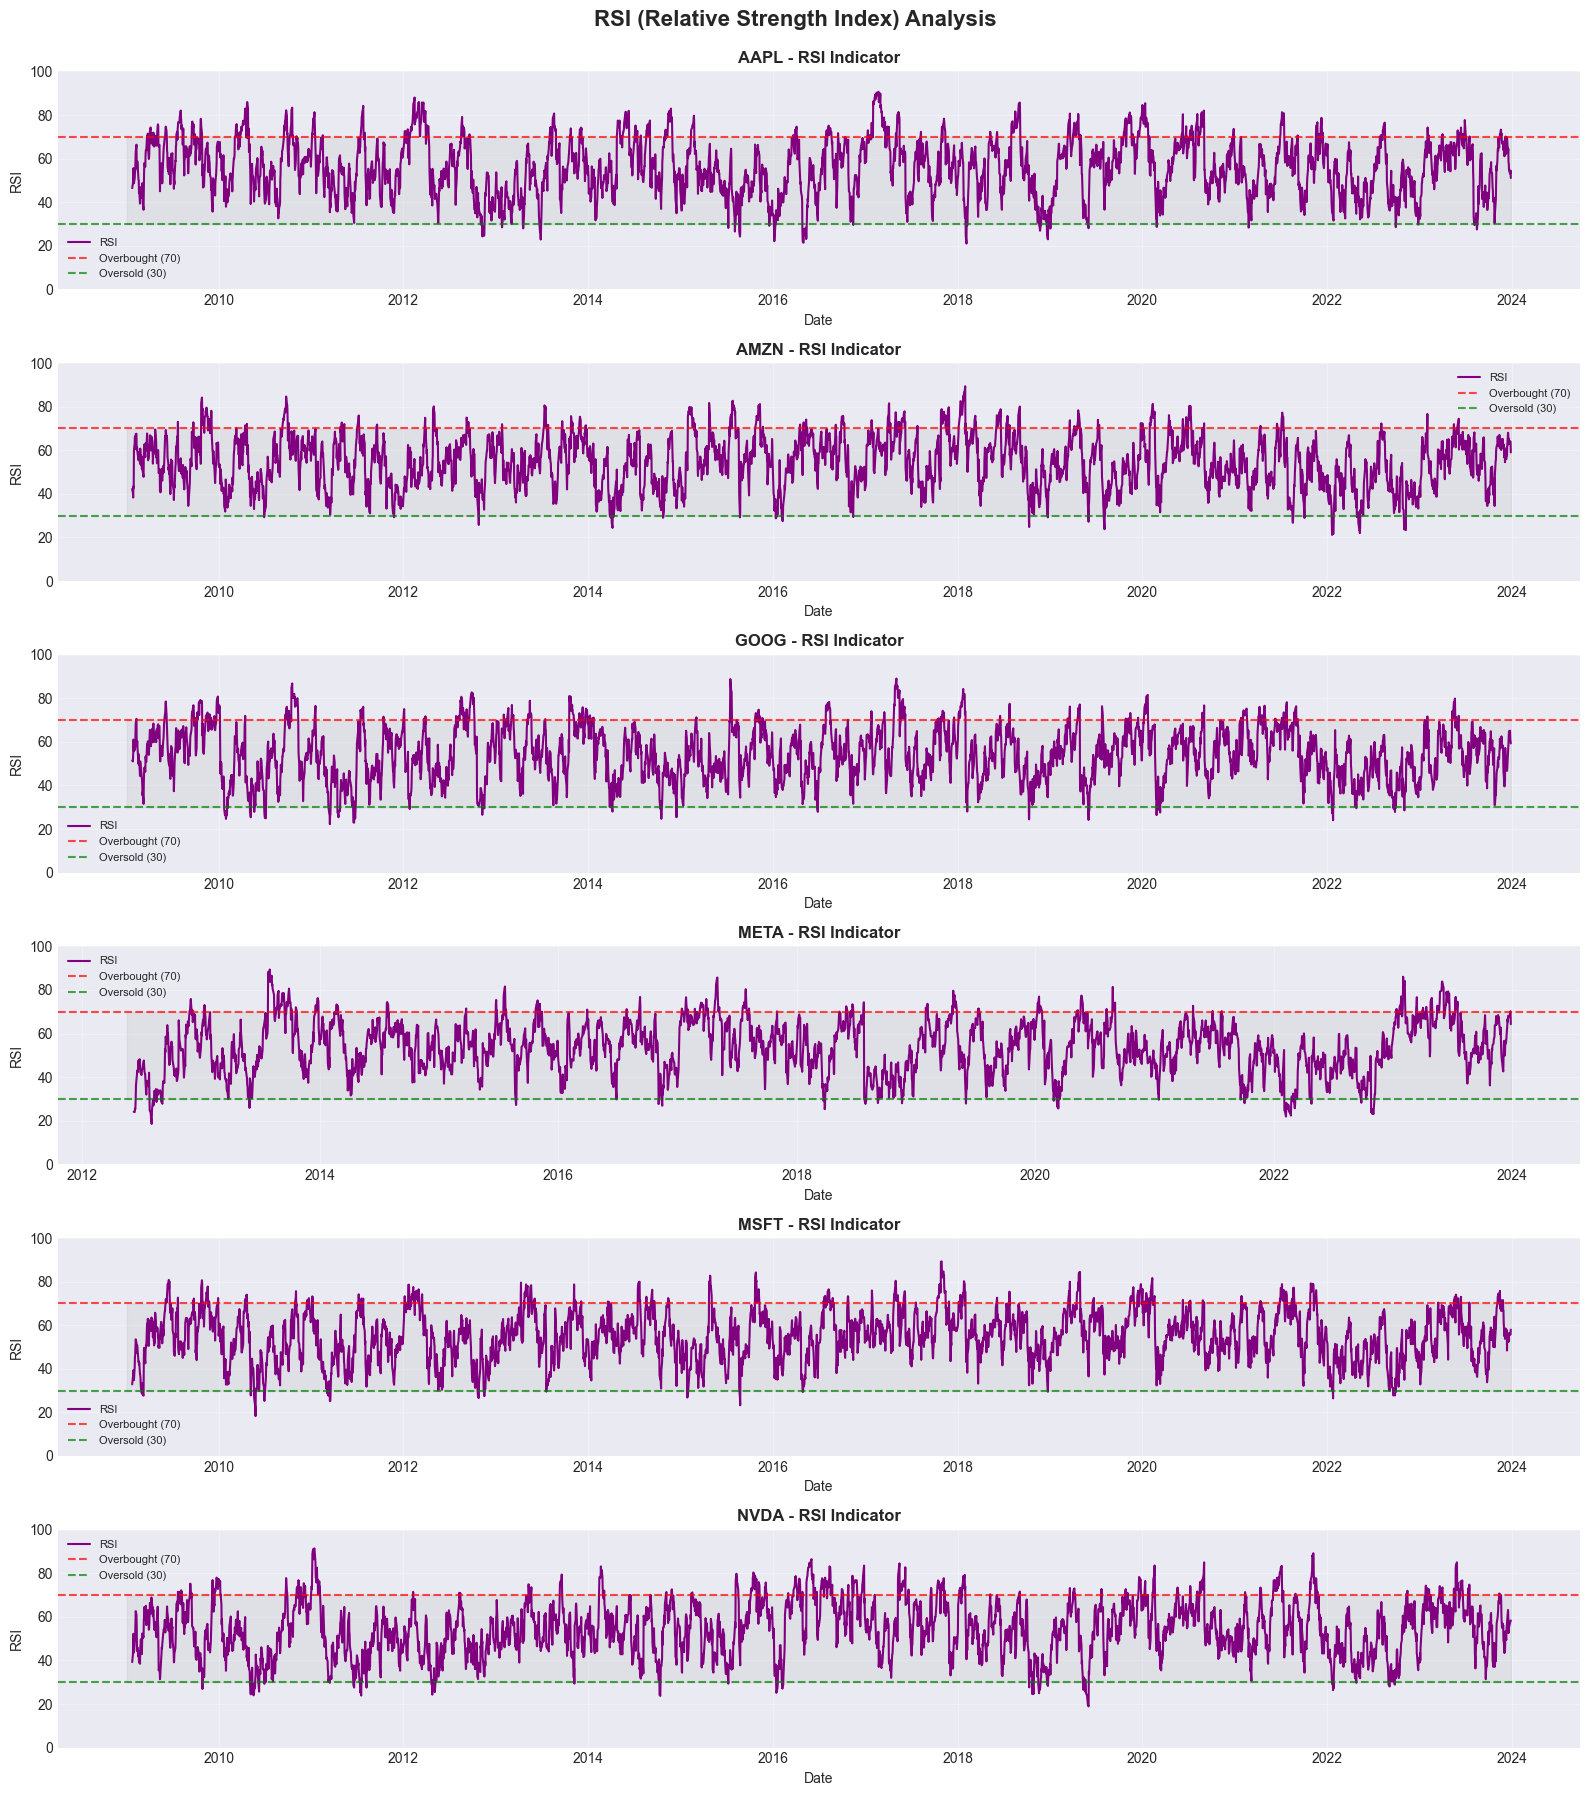

Saved: figures/rsi_analysis.png


In [27]:
# Visualize RSI for each stock
if TALIB_AVAILABLE and any('RSI' in df.columns for df in stock_data.values()):
    fig, axes = plt.subplots(len(stock_data), 1, figsize=(16, 3*len(stock_data)))
    if len(stock_data) == 1:
        axes = [axes]
    
    fig.suptitle('RSI (Relative Strength Index) Analysis', fontsize=16, fontweight='bold', y=0.995)
    
    for idx, (stock, df) in enumerate(stock_data.items()):
        ax = axes[idx]
        
        if 'RSI' in df.columns:
            ax.plot(df.index, df['RSI'], label='RSI', linewidth=1.5, color='purple')
            ax.axhline(y=70, color='r', linestyle='--', alpha=0.7, label='Overbought (70)')
            ax.axhline(y=30, color='g', linestyle='--', alpha=0.7, label='Oversold (30)')
            ax.fill_between(df.index, 30, 70, alpha=0.1, color='gray')
            
            ax.set_title(f'{stock} - RSI Indicator', fontsize=12, fontweight='bold')
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('RSI', fontsize=10)
            ax.set_ylim(0, 100)
            ax.legend(loc='best', fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/rsi_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: figures/rsi_analysis.png")


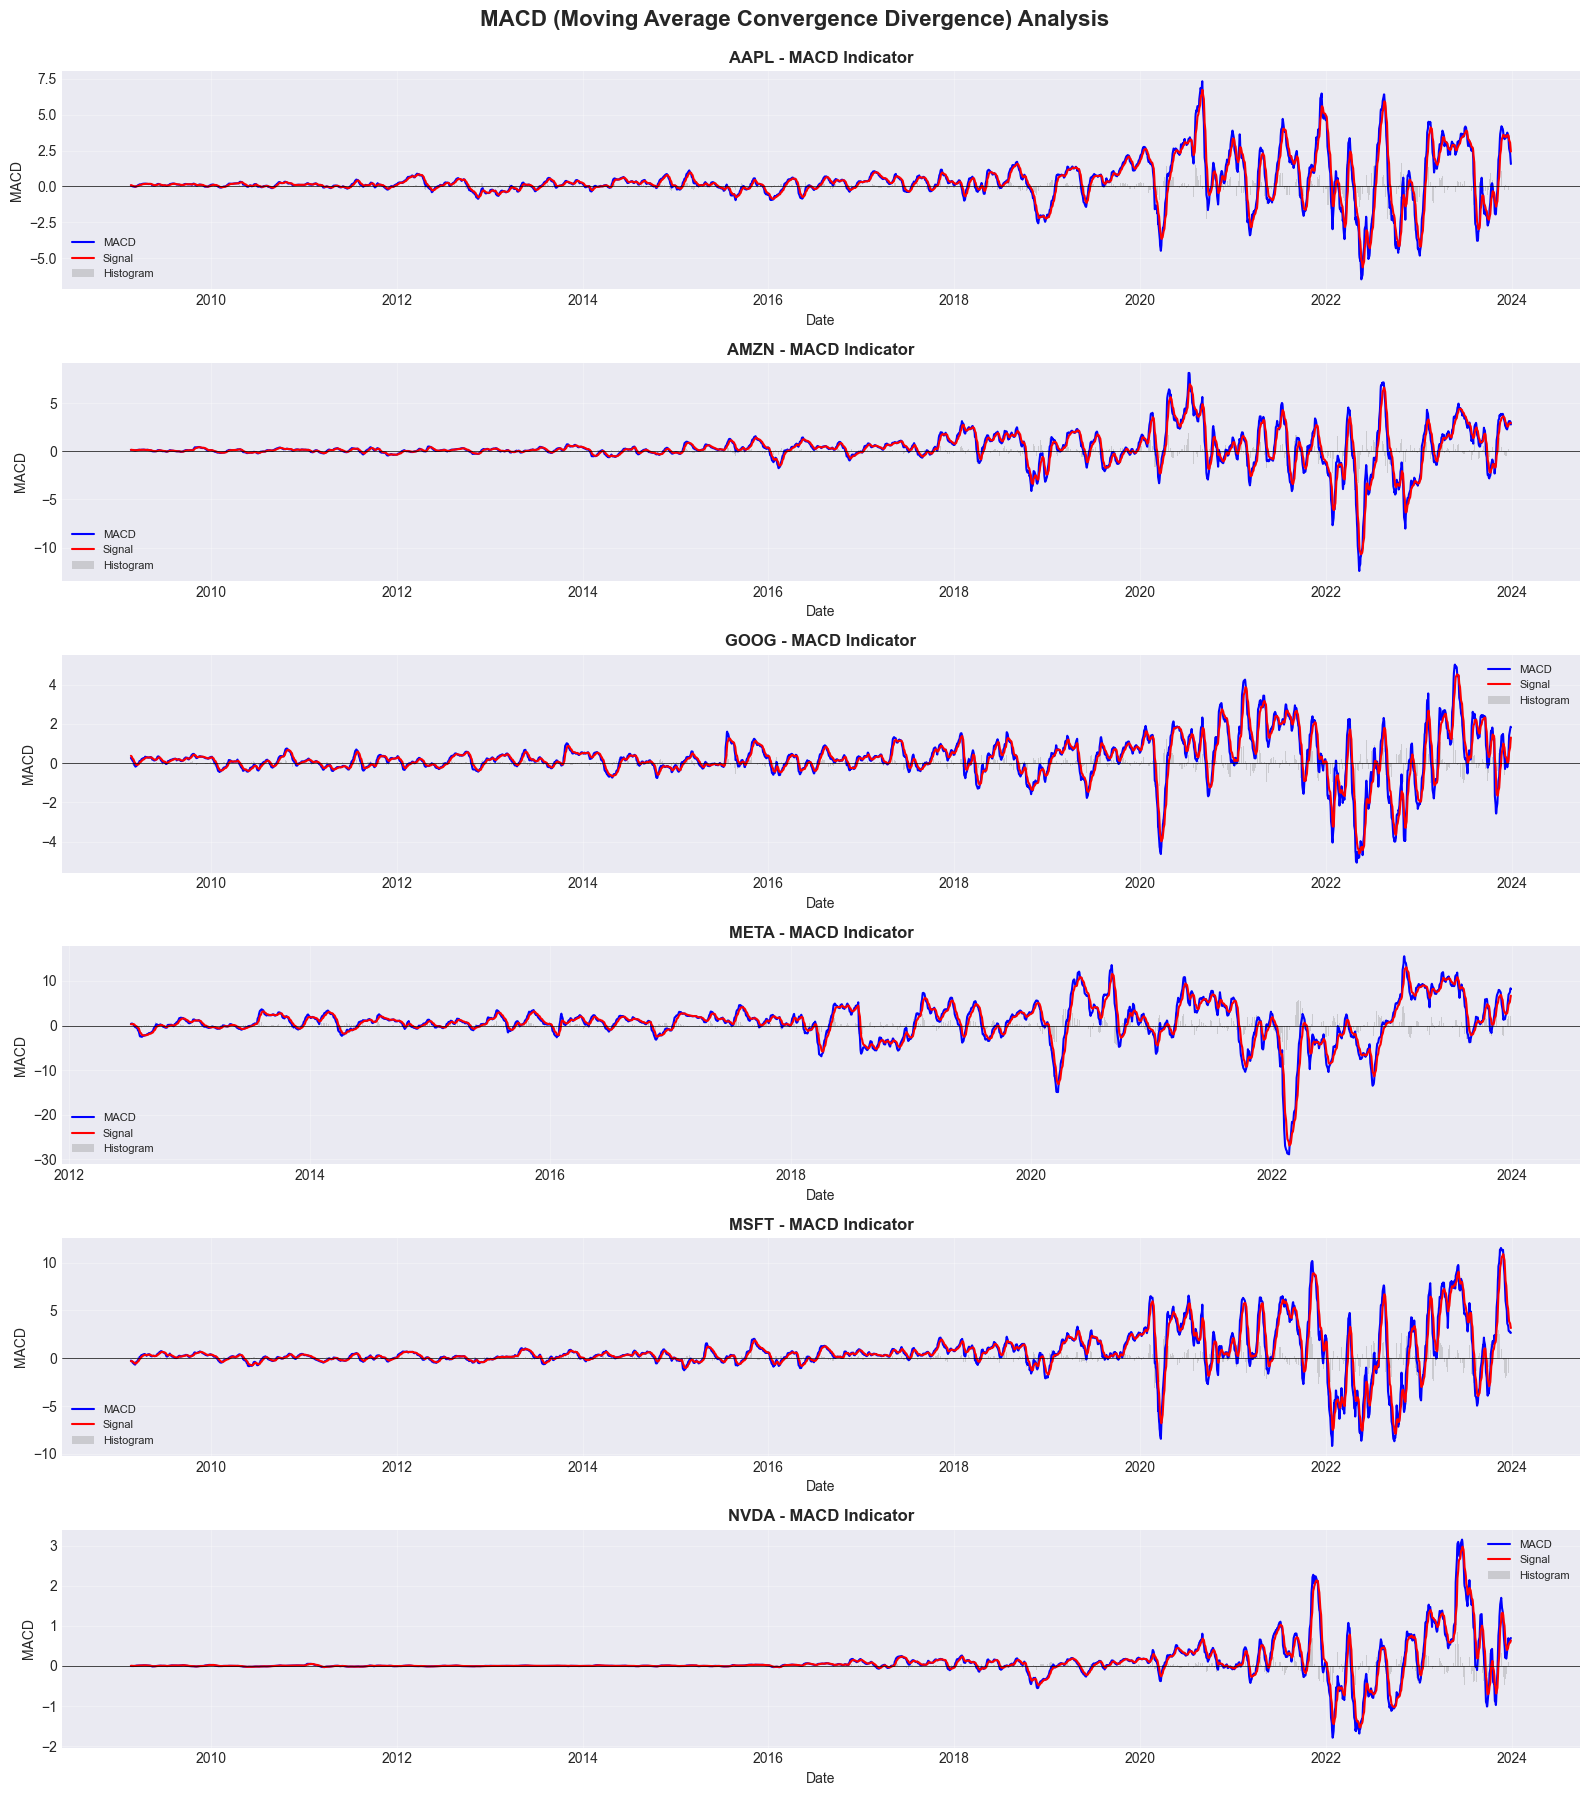

Saved: figures/macd_analysis.png


In [28]:
# Visualize MACD for each stock
if TALIB_AVAILABLE and any('MACD' in df.columns for df in stock_data.values()):
    fig, axes = plt.subplots(len(stock_data), 1, figsize=(16, 3*len(stock_data)))
    if len(stock_data) == 1:
        axes = [axes]
    
    fig.suptitle('MACD (Moving Average Convergence Divergence) Analysis', fontsize=16, fontweight='bold', y=0.995)
    
    for idx, (stock, df) in enumerate(stock_data.items()):
        ax = axes[idx]
        
        if 'MACD' in df.columns and 'MACD_signal' in df.columns:
            ax.plot(df.index, df['MACD'], label='MACD', linewidth=1.5, color='blue')
            ax.plot(df.index, df['MACD_signal'], label='Signal', linewidth=1.5, color='red')
            ax.bar(df.index, df['MACD_hist'], label='Histogram', alpha=0.3, color='gray')
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            
            ax.set_title(f'{stock} - MACD Indicator', fontsize=12, fontweight='bold')
            ax.set_xlabel('Date', fontsize=10)
            ax.set_ylabel('MACD', fontsize=10)
            ax.legend(loc='best', fontsize=8)
            ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('figures/macd_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Saved: figures/macd_analysis.png")


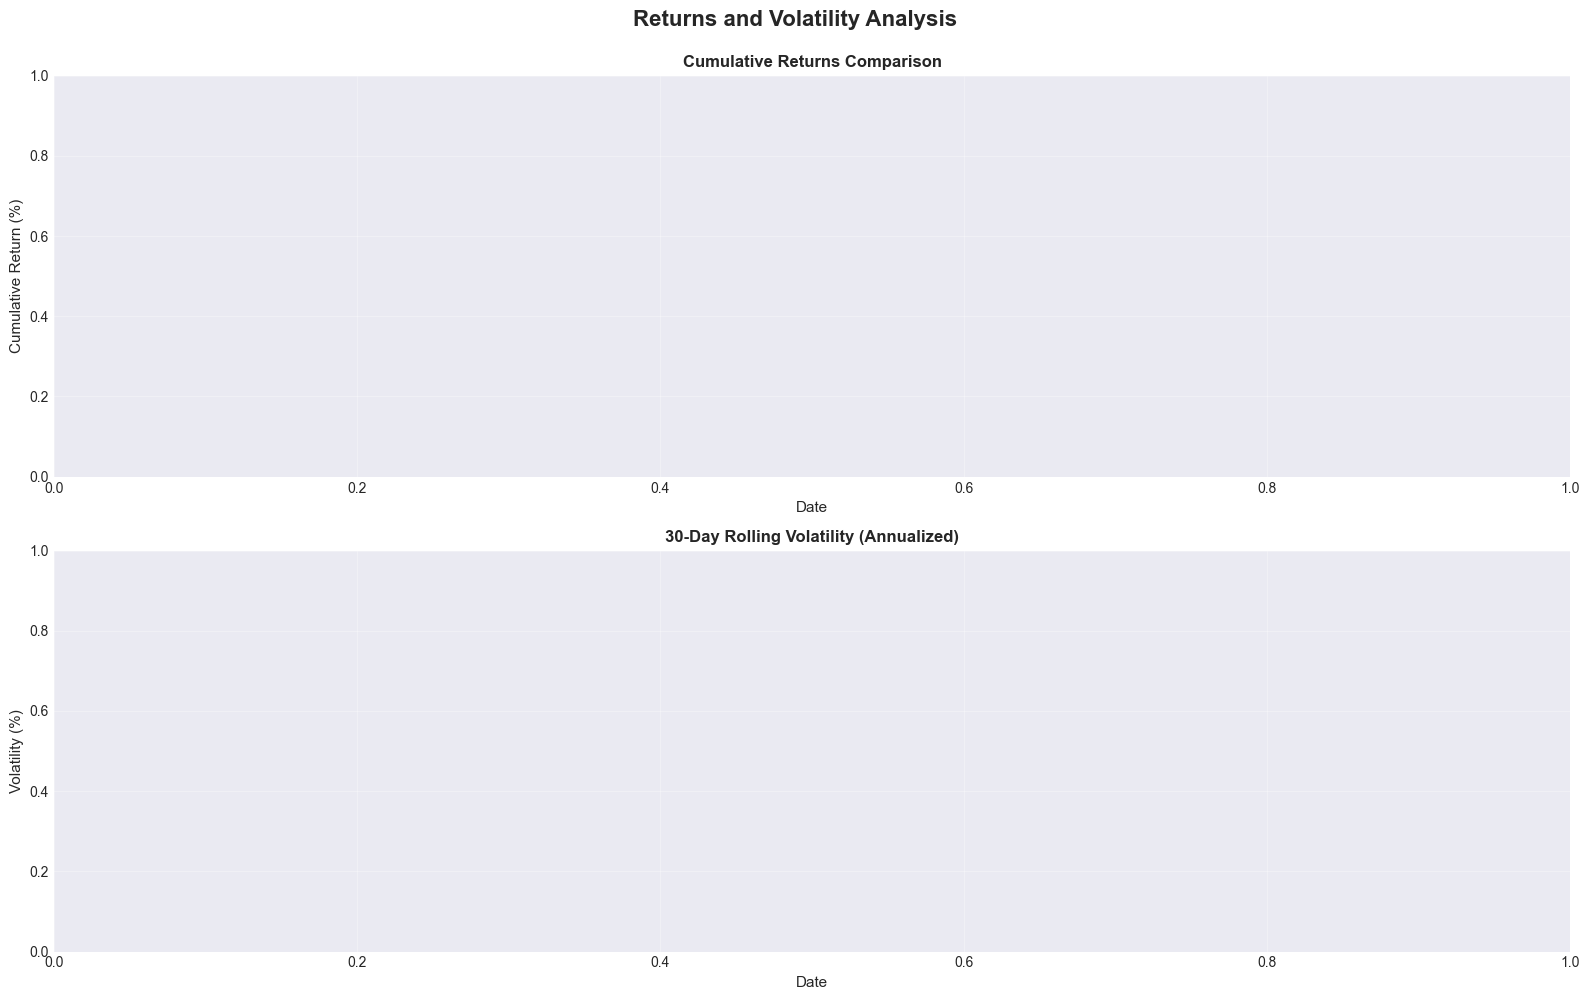

Saved: figures/returns_volatility_analysis.png


In [30]:
# Visualize returns and volatility
fig, axes = plt.subplots(2, 1, figsize=(16, 10))
fig.suptitle('Returns and Volatility Analysis', fontsize=16, fontweight='bold', y=0.995)

# Plot 1: Cumulative returns comparison
ax1 = axes[0]
for stock, df in stock_data.items():
    if 'Cumulative_Return' in df.columns:
        ax1.plot(df.index, df['Cumulative_Return'] * 100, label=stock, linewidth=1.5)

ax1.set_title('Cumulative Returns Comparison', fontsize=12, fontweight='bold')
ax1.set_xlabel('Date', fontsize=11)
ax1.set_ylabel('Cumulative Return (%)', fontsize=11)
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 2: Volatility comparison
ax2 = axes[1]
for stock, df in stock_data.items():
    if 'Volatility_30' in df.columns:
        ax2.plot(df.index, df['Volatility_30'] * 100, label=stock, linewidth=1.5, alpha=0.7)

ax2.set_title('30-Day Rolling Volatility (Annualized)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Volatility (%)', fontsize=11)
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/returns_volatility_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print("Saved: figures/returns_volatility_analysis.png")


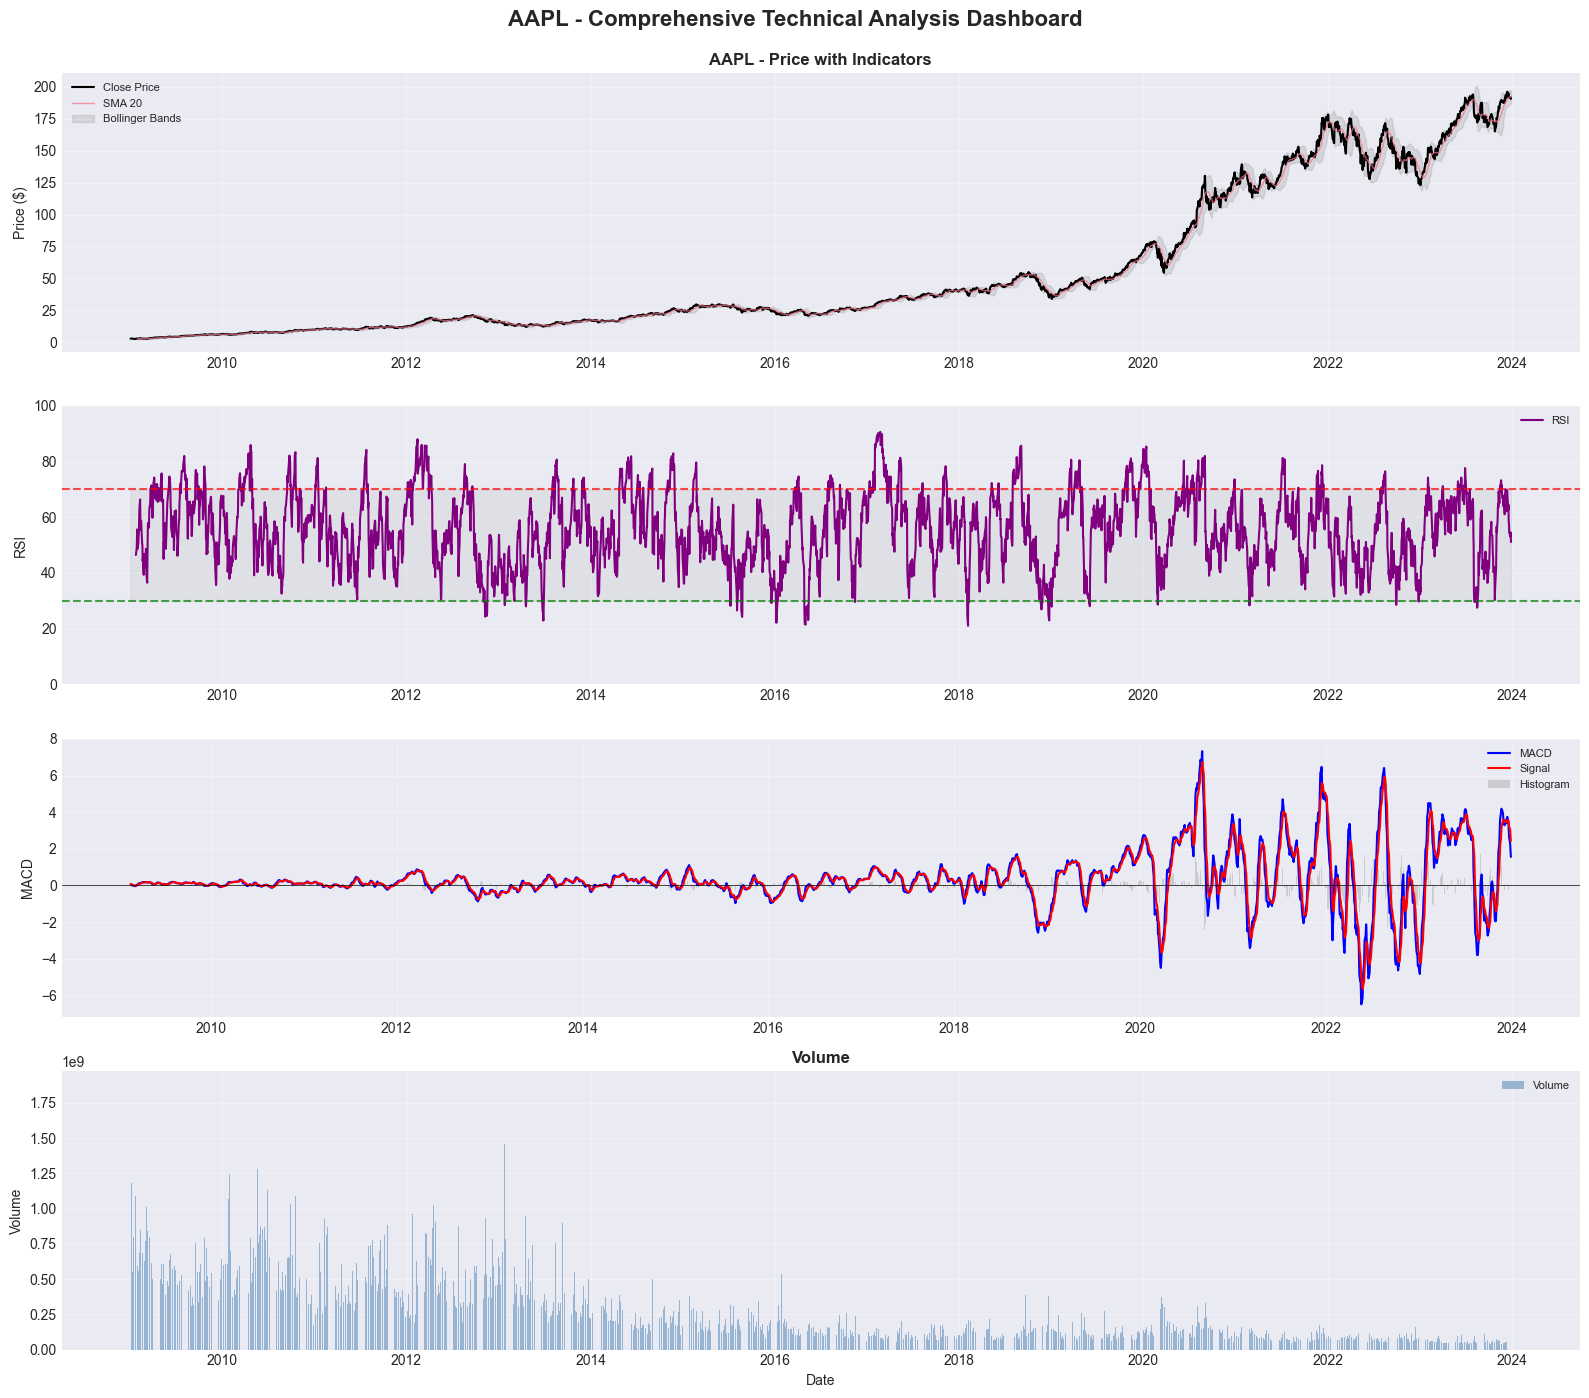

Saved: figures/AAPL_comprehensive_dashboard.png


In [31]:
# Create comprehensive dashboard for one stock (example: AAPL)
if 'AAPL' in stock_data:
    stock = 'AAPL'
    df = stock_data[stock]
    
    fig, axes = plt.subplots(4, 1, figsize=(16, 14))
    fig.suptitle(f'{stock} - Comprehensive Technical Analysis Dashboard', fontsize=16, fontweight='bold', y=0.995)
    
    # Plot 1: Price with moving averages and Bollinger Bands
    ax1 = axes[0]
    ax1.plot(df.index, df['Close'], label='Close Price', linewidth=1.5, color='black')
    if 'SMA_20' in df.columns:
        ax1.plot(df.index, df['SMA_20'], label='SMA 20', linewidth=1, alpha=0.7)
    if 'BB_upper' in df.columns and 'BB_lower' in df.columns:
        ax1.fill_between(df.index, df['BB_upper'], df['BB_lower'], alpha=0.2, label='Bollinger Bands', color='gray')
    ax1.set_title(f'{stock} - Price with Indicators', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=10)
    ax1.legend(loc='best', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: RSI
    ax2 = axes[1]
    if 'RSI' in df.columns:
        ax2.plot(df.index, df['RSI'], label='RSI', linewidth=1.5, color='purple')
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.7)
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.7)
        ax2.fill_between(df.index, 30, 70, alpha=0.1, color='gray')
        ax2.set_ylabel('RSI', fontsize=10)
        ax2.set_ylim(0, 100)
        ax2.legend(loc='best', fontsize=8)
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: MACD
    ax3 = axes[2]
    if 'MACD' in df.columns:
        ax3.plot(df.index, df['MACD'], label='MACD', linewidth=1.5, color='blue')
        ax3.plot(df.index, df['MACD_signal'], label='Signal', linewidth=1.5, color='red')
        ax3.bar(df.index, df['MACD_hist'], label='Histogram', alpha=0.3, color='gray')
        ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        ax3.set_ylabel('MACD', fontsize=10)
        ax3.legend(loc='best', fontsize=8)
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Volume
    ax4 = axes[3]
    ax4.bar(df.index, df['Volume'], alpha=0.5, color='steelblue', label='Volume')
    ax4.set_title('Volume', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Date', fontsize=10)
    ax4.set_ylabel('Volume', fontsize=10)
    ax4.legend(loc='best', fontsize=8)
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'figures/{stock}_comprehensive_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: figures/{stock}_comprehensive_dashboard.png")


## Summary and Key Findings

**Key Insights from Quantitative Analysis:**

1. **Technical Indicators:**
   - [To be filled after running the notebook]

2. **Financial Metrics:**
   - [To be filled after running the notebook]

3. **Trading Signals:**
   - [To be filled after running the notebook]

4. **Comparative Analysis:**
   - [To be filled after running the notebook]

**Next Steps:**
- Proceed to Task 3: Correlation between News and Stock Movement
- Use these indicators for sentiment correlation analysis
